<a href="https://colab.research.google.com/github/wanderingxplorer1/ml-projects/blob/main/image-classification/KaggleCatsVsDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Cat's vs Dogs
Create a model to classify whether images contain either a dog or a cat.

https://www.kaggle.com/c/dogs-vs-cats

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from shutil import copyfile, rmtree
import random
import matplotlib.image as mpimg

# Download the data
We will be using the Kaggle cat's vs dogs dataset to create a model to predict
whether the image is og a cat or a dog.

The dataset can be found in https://www.kaggle.com/c/dogs-vs-cats/data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
! mkdir ~/.kaggle
! cp /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:21<00:00, 43.1MB/s]
100% 812M/812M [00:21<00:00, 40.0MB/s]


In [5]:
! unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
! unzip train.zip

In [7]:
try:
    rmtree('/tmp/cats-v-dogs')
except OSError:
    pass
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

# Prepare the data in directories


In [8]:
SOURCE_DIR = "train"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs"

import random
from shutil import copyfile, rmtree

def split_cats_dogs(source_dir):
    cat_files = []
    dog_files = []
    for filename in os.listdir(source_dir):
        file = os.path.join(source_dir, filename)
        if os.path.getsize(file) > 0:
            if filename.startswith("cat"):
              cat_files.append(filename)
            else:
              dog_files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")
    return cat_files, dog_files

def split_data(source_dir, files, training_dir, testing_dir, split_size):
    training_length = int(len(files) * split_size)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = os.path.join(source_dir, filename)
        destination = os.path.join(training_dir, filename)
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = os.path.join(source_dir, filename)
        destination = os.path.join(testing_dir, filename)
        copyfile(this_file, destination)

cat_files, dog_files = split_cats_dogs(SOURCE_DIR)
split_data(SOURCE_DIR, cat_files, TRAINING_CATS_DIR, TESTING_CATS_DIR, 0.9)
split_data(SOURCE_DIR, dog_files, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, 0.9)

# Visualize the created data

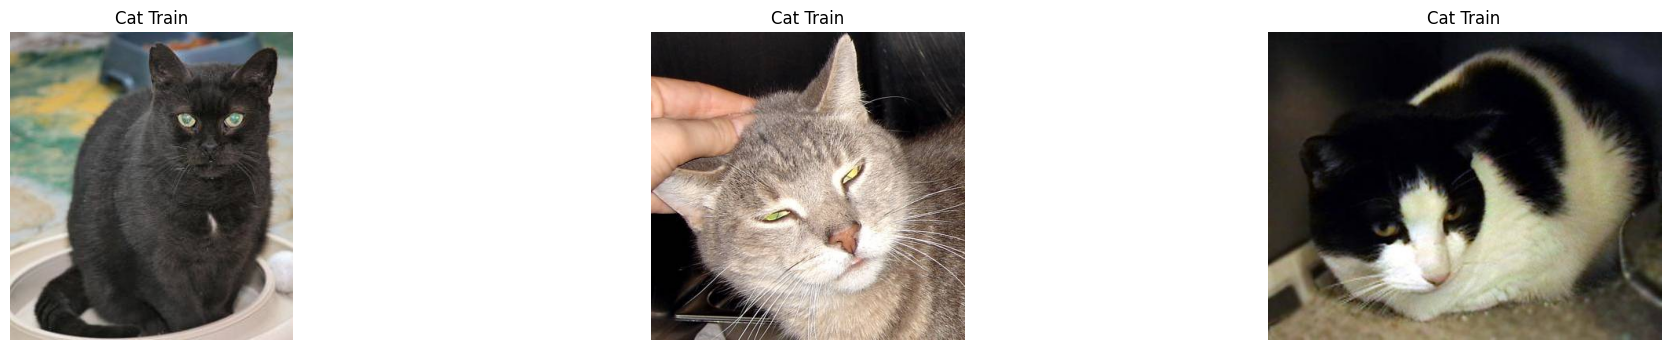

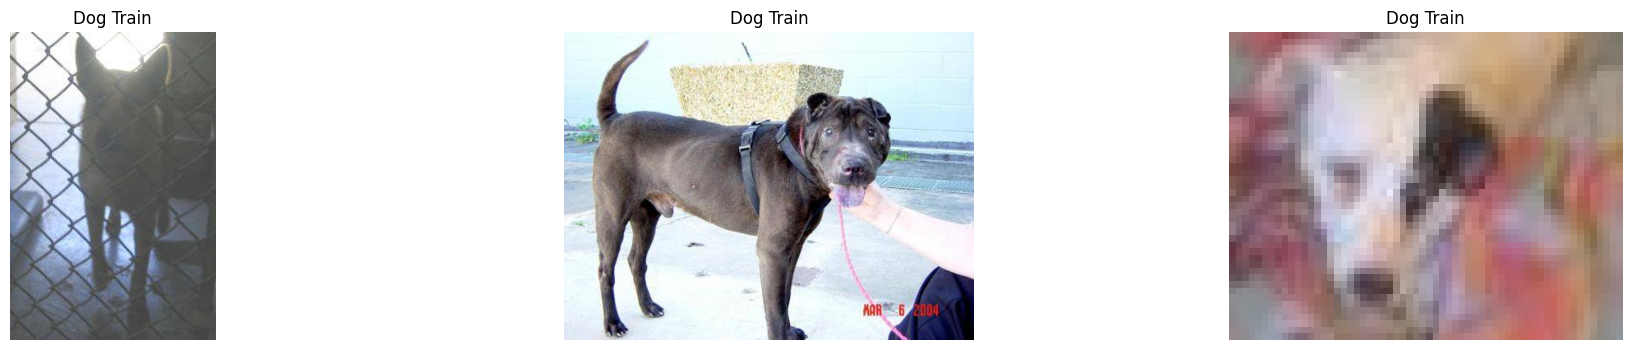

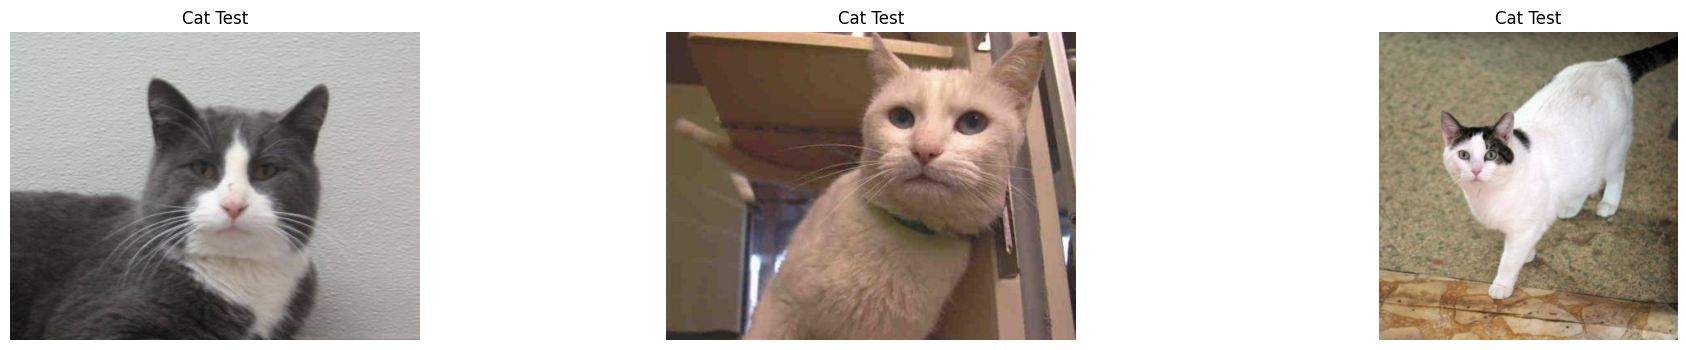

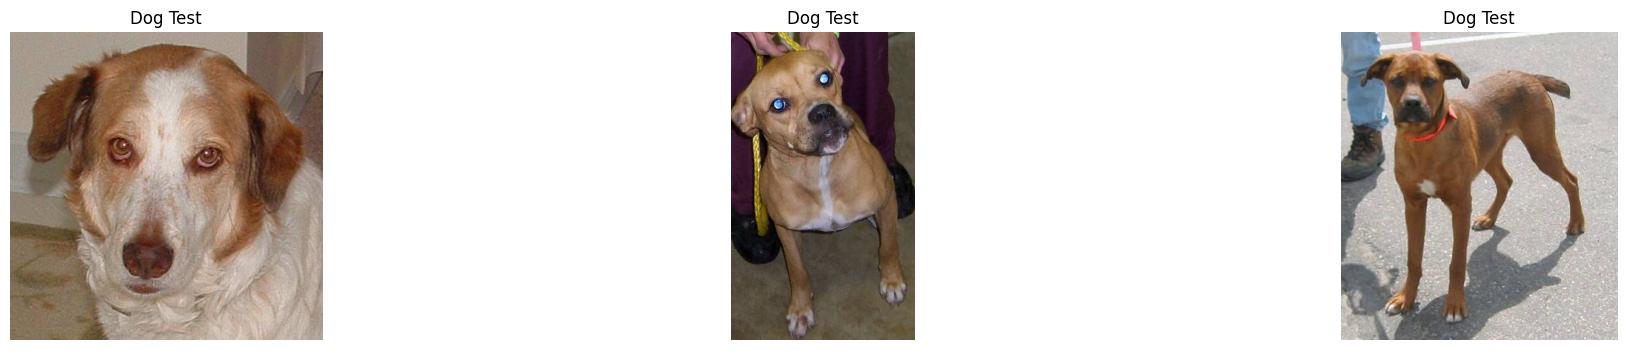

In [10]:
def display_images(image_paths, category):
    plt.figure(figsize=(24, 4))  # Set figure size for the display
    for i, img_path in enumerate(image_paths):
        plt.subplot(1, 3, i + 1)  # Arrange images in a single row
        img = mpimg.imread(os.path.join('train', img_path))  # Read the image file
        plt.imshow(img)  # Display the image
        plt.title(category)  # Set the title to the category (cat or dog)
        plt.axis('off')  # Hide the axis for a cleaner look
    plt.show()  # Display the plot

def populate_image_filenames(directory, files):
    for filename in os.listdir(directory):
        files.append(os.path.join(directory, filename))
# List all cat and dog filenames in the "train" directory
cat_training_images = []
dog_training_images = []
cat_testing_images = []
dog_testing_images = []
populate_image_filenames(TRAINING_CATS_DIR, cat_training_images)
populate_image_filenames(TESTING_CATS_DIR, cat_testing_images)
populate_image_filenames(TRAINING_DOGS_DIR, dog_training_images)
populate_image_filenames(TESTING_DOGS_DIR, dog_testing_images)

# Randomly select three images from each category and display them.
display_images(random.sample(cat_training_images, 3), 'Cat Train')
display_images(random.sample(dog_training_images, 3), 'Dog Train')
display_images(random.sample(cat_testing_images, 3), 'Cat Test')
display_images(random.sample(dog_testing_images, 3), 'Dog Test')

# Prepare the dataset
Do some image augmengtation while reading the images from the dis.

In [11]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=100,
    class_mode='binary',
    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"

validation_datagen = ImageDataGenerator(
    rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=100,
    class_mode='binary',
    target_size=(150, 150))

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# Build the model

In [12]:
def build_simple_cnn_model():
    model = tf.keras.models.Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.25),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.25),
        Dense(1, activation='sigmoid')
    ])
    return model

model = build_simple_cnn_model()
model.compile(loss='binary_crossentropy', optimizer=Adam(3e-04), metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x=train_generator, validation_data=validation_generator, epochs=40, callbacks=[callback])

Epoch 1/40
225/225 [==============================] - 189s 796ms/step - loss: 0.6517 - accuracy: 0.6068 - val_loss: 0.5910 - val_accuracy: 0.6880
Epoch 2/40
225/225 [==============================] - 183s 813ms/step - loss: 0.5839 - accuracy: 0.6845 - val_loss: 0.5159 - val_accuracy: 0.7500
Epoch 3/40
225/225 [==============================] - 191s 850ms/step - loss: 0.5497 - accuracy: 0.7172 - val_loss: 0.4615 - val_accuracy: 0.7780
Epoch 4/40
225/225 [==============================] - 182s 808ms/step - loss: 0.5183 - accuracy: 0.7420 - val_loss: 0.4470 - val_accuracy: 0.7896
Epoch 5/40
225/225 [==============================] - 183s 811ms/step - loss: 0.4910 - accuracy: 0.7597 - val_loss: 0.4078 - val_accuracy: 0.8156
Epoch 6/40
225/225 [==============================] - 185s 821ms/step - loss: 0.4591 - accuracy: 0.7825 - val_loss: 0.3738 - val_accuracy: 0.8324
Epoch 7/40
225/225 [==============================] - 180s 802ms/step - loss: 0.4404 - accuracy: 0.7961 - val_loss: 0.3883 -

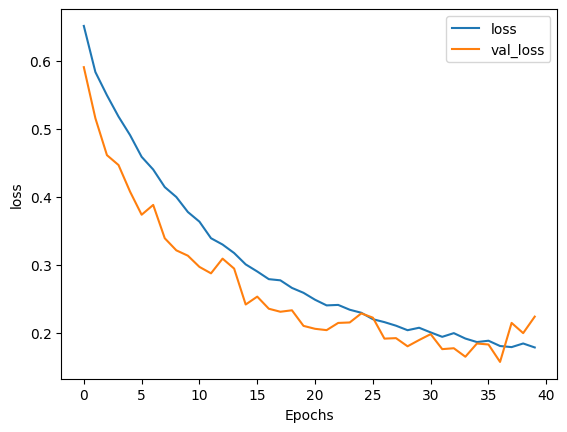

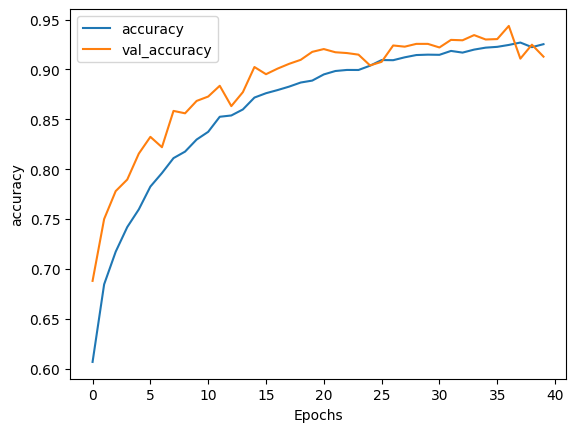

In [14]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "loss")
plot_graphs(history, "accuracy")

# Predict on a test image
Upload any image and have the model predict whether it's a dog or a cat.

In [21]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

def predict_uloaded_image(classifier, uploaded):
    for fn in uploaded.keys():
        # predicting images
        path = '/content/' + fn
        img = load_img(path, target_size=(150, 150))
        x = img_to_array(img)
        x /= 255
        x = np.expand_dims(x, axis=0)

        image_tensor = np.vstack([x])
        classes = classifier.predict(image_tensor)
        print(classes[0])
        if classes[0]>0.5:
            print(fn + " is a dog")
        else:
            print(fn + " is a cat")
uploaded = files.upload()
predict_uloaded_image(model, uploaded)

Saving leo.jpeg to leo.jpeg
1/1 [==============================] - 0s 18ms/step
[0.9893684]
leo.jpeg is a dog


# Save the model for future use

In [16]:
model.save('cats_v_dogs_simple_cnn.keras')

In [22]:
saved_model = tf.keras.models.load_model('cats_v_dogs_simple_cnn.keras')
uploaded = files.upload()
predict_uloaded_image(saved_model, uploaded)

Saving leo.jpeg to leo (1).jpeg
1/1 [==============================] - 0s 110ms/step
[0.9893684]
leo (1).jpeg is a dog
